In [595]:
import numpy as np
import pandas as pd
import csv
import pylab as pl
from matplotlib import collections  as mc

In [596]:
'''class Tree:
    def __init__(self):
        self.root=None
        self.graph={}
        self.weights={}
    def set_edge(self,u,v,d):
        if not u in self.graph:
            self.graph[u]={}
            self.weights[u]=0
        self.graph[u][v]=d
        if not v in self.graph:
            self.graph[v]={}
            self.weights[v]=0
        self.graph[v][u]=d
    def __str__(self):
        return str(self.graph)
    def analysis(self):
        pass'''

'class Tree:\n    def __init__(self):\n        self.root=None\n        self.graph={}\n        self.weights={}\n    def set_edge(self,u,v,d):\n        if not u in self.graph:\n            self.graph[u]={}\n            self.weights[u]=0\n        self.graph[u][v]=d\n        if not v in self.graph:\n            self.graph[v]={}\n            self.weights[v]=0\n        self.graph[v][u]=d\n    def __str__(self):\n        return str(self.graph)\n    def analysis(self):\n        pass'

In [597]:
class NbyNTable:
    def __init__(self,l:np.ndarray):
        self.namelist=l
        self.table=np.zeros((len(l),len(l)))
    def get(self,name1,name2):
        return float(self.table[np.where(self.namelist==name1)[0],np.where(self.namelist==name2)[0]])
    def getrow(self,name1):
        return self.table[np.where(self.namelist==name1)[0]]
    def getcol(self,name2):
        return self.table[np.where(self.namelist==name2)[0]]
    def set(self,name1,name2,v):
        self.table[np.where(self.namelist==name1)[0],np.where(self.namelist==name2)[0]]=v
        return 0
    def clear(self,v=0):
        self.table.fill(v)
    def express(self,trivial_value=0):
        for i in range(self.table.shape[0]):
            for j in range(self.table.shape[1]):
                if self.get(self.namelist[i],self.namelist[j])!=trivial_value:
                    print(self.namelist[i],"->",self.namelist[j],":",self.get(self.namelist[i],self.namelist[j]))
                

In [598]:
class UDG:
    def __init__(self,is_udg=True):
        self.is_udg=is_udg
        self.graph={}
        self.weights={}
    def set_edge(self,u,v,d):
        if not u in self.graph:
            self.graph[u]={}
            self.weights[u]=0
        self.graph[u][v]=d
        if not self.is_udg:return
        if not v in self.graph:
            self.graph[v]={}
            self.weights[v]=0
        self.graph[v][u]=d
    def del_edge(self,u,v):
        self.graph[u].pop(v,None)
        if not self.is_udg:return
        self.graph[v].pop(u,None)
    def __str__(self):
        return str(self.graph)
    def getnodes(self):
        return self.graph.keys()
    def getgraph(self):
        return self.graph
    def getSPT(self,n,from_root=True):
        if n not in self.graph:
            raise ValueError("n not in graph!")
        else:
            dis={}
            pi={}
            vis={}
            for i in self.graph:
                dis[i]=np.inf
                pi[i]=None
                vis[i]=False
            dis[n]=0
            queue=[n]
            vis[n]=True
            while len(queue)>0:
                u=queue.pop(0)
                for v in self.graph[u]:
                    if not vis[v] and v not in queue:
                        queue.append(v)
                        vis[v]=True
                    if dis[v]>dis[u]+self.graph[u][v]:
                        dis[v]=dis[u]+self.graph[u][v]
                        pi[v]=u
            spt=UDG(is_udg=False)
            for u in pi:
                if not(u is None or pi[u] is None):
                    if from_root:
                        spt.set_edge(pi[u],u,self.graph[u][pi[u]])
                    else:
                        spt.set_edge(u,pi[u],self.graph[u][pi[u]])
            spt.weights=self.weights.copy()
            return spt
    def traffic(self,table:NbyNTable,cities):
        len_table=len(table.table)
        edge_traffic=NbyNTable(table.namelist)
        distance_table=NbyNTable(table.namelist)
        distance_table.table.fill(np.inf)
        transfer_traffic=np.zeros(len_table)
        for n in self.getnodes():
            dis={}
            pi={}
            vis={}
            for i in self.graph:
                dis[i]=np.inf
                pi[i]=None
                vis[i]=False
            dis[n]=0
            queue=[n]
            vis[n]=True
            while len(queue)>0:
                u=queue.pop(0)
                for v in self.graph[u]:
                    if not vis[v] and v not in queue:
                        queue.append(v)
                        vis[v]=True
                    if dis[v]>dis[u]+self.graph[u][v]:
                        dis[v]=dis[u]+self.graph[u][v]
                        pi[v]=u
            #print(n,pi)
            # pi is to the root, j->i
            for i in range(len_table):
                iname=table.namelist[i]
                if iname in pi:
                    tempname=iname[:]
                    while tempname!=n:
                        nextname=pi[tempname]
                        edge_traffic.set(nextname,tempname,edge_traffic.get(nextname,tempname)+table.get(n,iname))
                        if nextname!=n:
                            transfer_traffic[np.where(table.namelist==nextname)[0][0]]+=table.get(n,iname)
                        tempname=nextname
                    tempname=iname[:]
                    d=0
                    while tempname!=n:
                        nextname=pi[tempname]
                        d+=distance(cities,nextname,tempname)
                        tempname=nextname
                    distance_table.set(n,iname,d)
                    distance_table.set(iname,n,d)
        return edge_traffic,distance_table,transfer_traffic
    def sum_length(self,cities):
        d=0
        for m in self.getnodes():
            for n in self.graph[m]:
                d+=distance(cities,m,n)
        if self.is_udg:
            d/=2
        return d
    def visualize(self):
        def getcoord(cities,name):
            name=name.split(",")
            name1=name[0]
            name2=name[1]
            l=cities.loc[(cities['city'] ==name1) & (cities['state_id'] ==name2)]
            return np.float64(l['lng']),np.float64(l['lat'])
        lines=[]
        for name1 in self.getnodes():
            for name2 in self.graph[name1]:
                lng1,lat1=getcoord(cities,name1)
                lng2,lat2=getcoord(cities,name2)
                lines.append([(lng1,lat1),(lng2,lat2)])
        c=[(1, 0, 0, 1) for i in lines]
        lc = mc.LineCollection(lines, colors=c, linewidths=1)
        fig, ax = pl.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)

In [599]:
def distance(cities,city1,city2):
    state1=city1.split(',')[1]
    city1=city1.split(',')[0]
    state2=city2.split(',')[1]
    city2=city2.split(',')[0]
    x1=np.deg2rad(float(cities.loc[(cities['city']==city1)&(cities['state_id']==state1)]['lng']))
    y1=np.deg2rad(float(cities.loc[(cities['city']==city1)&(cities['state_id']==state1)]['lat']))
    x2=np.deg2rad(float(cities.loc[(cities['city']==city2)&(cities['state_id']==state2)]['lng']))
    y2=np.deg2rad(float(cities.loc[(cities['city']==city2)&(cities['state_id']==state2)]['lat']))
    return 6371*np.arccos(np.cos(y1)*np.cos(y2)*np.cos(x1-x2)+np.sin(y1)*np.sin(y2))

In [600]:
def addcities(udg:UDG,cities,city1,city2):
    if city1!=city2:
        udg.set_edge(city1,city2,distance(cities,city1,city2))

In [601]:
cities=pd.read_csv('uscities.csv')


In [602]:
city_names=cities[:100][["city"]].values.reshape(-1)
city_states=cities[:100][["state_id"]].values.reshape(-1)
city_list=[]
for i in range(len(city_names)):
    city_list.append(city_names[i]+","+city_states[i])
city_list=np.array(city_list)
'''traffic_table=NbyNTable(city_list)'''

'traffic_table=NbyNTable(city_list)'

In [603]:
traffic_list=[]
with open("traffic.csv") as file:
    spamreader = csv.reader(file,delimiter=',')
    for row in spamreader:
        a=row[0]+','+row[1]
        b=row[2]+','+row[3]
        c=int(row[4])
        traffic_list.append([a,b,c])

In [604]:
'''edge_traffic,distance_table,transfer_traffic=udg.traffic(traffic_table,cities)
distance_table.express(trivial_value=np.inf)
#distance_table.express(np.inf)
for i,v in enumerate(transfer_traffic):
    if v!=0:
        print(f"{city_list[i]}:{v}")'''


'edge_traffic,distance_table,transfer_traffic=udg.traffic(traffic_table,cities)\ndistance_table.express(trivial_value=np.inf)\n#distance_table.express(np.inf)\nfor i,v in enumerate(transfer_traffic):\n    if v!=0:\n        print(f"{city_list[i]}:{v}")'

In [605]:
def detour_cost(distance_table:NbyNTable,traffic_table:NbyNTable,cities):
    detour_table=NbyNTable(distance_table.namelist)
    detour_table.table.fill(np.inf)
    n=len(detour_table.namelist)
    for i in range(n):
        for j in range(n):
            if distance_table.table[i,j]!=np.inf:
                detour_table.table[i,j]=traffic_table.table[i,j]*(distance_table.table[i,j]-distance(cities,distance_table.namelist[i],distance_table.namelist[j]))
    return detour_table
'''detour_table=detour(distance_table,cities)
detour_table.express(np.inf)'''

'detour_table=detour(distance_table,cities)\ndetour_table.express(np.inf)'

In [606]:
'''cost_table=NbyNTable(city_list)
cost_table.table=np.multiply(distance_table.table,traffic_table.table)
cost_table.express()'''

'cost_table=NbyNTable(city_list)\ncost_table.table=np.multiply(distance_table.table,traffic_table.table)\ncost_table.express()'

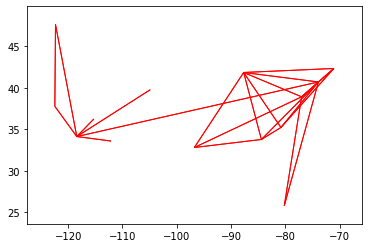

In [607]:
# Profit of an edge
def build_edges(traffic_list,cities,city_list):
    coef=13.5
    t_list=[]
    udg=UDG()
    c_list=[]
    traffic_table=NbyNTable(np.array(city_list))
    for i,v in enumerate(traffic_list):
        if not v[0] in c_list:
            c_list.append(v[0])
        if not v[1] in c_list:
            c_list.append(v[1])
        t_list.append([v[0],v[1],v[2],v[2]/distance(cities,v[0],v[1])])
        if v[2]/distance(cities,v[0],v[1])>=1/coef:
            addcities(udg,cities,v[0],v[1])
        else:
            traffic_table.set(v[0],v[1],v[2])
    #t_list=sorted(t_list,key=lambda x:-x[3])
    return udg,traffic_table
mygraph,traffic_table=build_edges(traffic_list,cities,city_list)
mygraph.visualize()

In [608]:
def analyze_route(udg:UDG,name1,name2,cities,traffic_table:NbyNTable):
    tra=max(traffic_table.get(name1,name2),traffic_table.get(name2,name1))
    coef=15
    if tra==0:
        return None,0
    else:
        # SPT based on name2
        spt=udg.getSPT(name2,from_root=False)
        spt_dist={}
        for c in spt.graph:
            d=0
            temp=c
            while temp!=name2:
                nextcity=list(spt.graph[temp].keys())[0]
                nextdist=list(spt.graph[temp].values())[0]
                d+=nextdist
                temp=nextcity
            spt_dist[c]=d
        #print(spt_dist)
        #spt_dist=sorted(spt_dist,key=lambda x:x[1])
        #print(spt_dist)
        d=spt_dist[name1] if name1 in spt_dist else np.inf
        current_lowest_cost=(coef+tra)*distance(cities,name1,name2)
        current_node=name2
        for c in spt_dist:
            cost=(coef+tra)*distance(cities,name1,c)+tra*spt_dist[c]
            #print(c,cost)
            if cost<current_lowest_cost:
                current_lowest_cost=cost
                current_node=c
        return  current_node,current_lowest_cost
            
            

In [609]:
def analyze_route_multi_source(udg:UDG,names1:list[str],name2:str,cities,traffic_table:NbyNTable):
    coef=15
    tra=0
    # SPT based on name2
    spt=udg.getSPT(name2,from_root=False)
    spt_dist={}
    for c in spt.graph:
        d=0
        temp=c
        while temp!=name2:
            nextcity=list(spt.graph[temp].keys())[0]
            nextdist=list(spt.graph[temp].values())[0]
            d+=nextdist
            temp=nextcity
        spt_dist[c]=d
    total_cost={x:0 for x in spt_dist.keys()}
    for name1 in names1:
        d=spt_dist[name1] if name1 in spt_dist else np.inf
        tra=traffic_table.get(name1,name2)
        current_cost=tra*d
        print(name2,(coef+tra)*distance(cities,name1,name2))
        for c in spt_dist:
            cost=(coef+tra)*distance(cities,name1,c)+tra*spt_dist[c]
            print(c,cost)
            total_cost[c]+=cost
    for c in total_cost:
        print(c,total_cost[c])

In [610]:
def analyze_route_multi_dest(udg:UDG,name1:str,names2:list[str],cities,traffic_table:NbyNTable):
    coef=15
    total_cost={}
    for name2 in names2:
        if name2 not in total_cost:
            total_cost[name2]=0
        tra=traffic_table.get(name1,name2)
        total_cost[name2]+=(coef+tra)*distance(cities,name2,name1)
        spt=udg.getSPT(name2,False)
        for c in spt.graph:
            d=0
            temp=c
            while temp!=name2:
                nextcity=list(spt.graph[temp].keys())[0]
                nextdist=list(spt.graph[temp].values())[0]
                d+=nextdist
                temp=nextcity
            if c not in total_cost:
                total_cost[c]=0
            total_cost[c]+=(coef+tra)*distance(cities,c,name1)+tra*d
    ret_city=min(total_cost,key=total_cost.get)
    ret_cost=total_cost[ret_city]
    return ret_city,ret_cost

In [611]:
def analyze_route_bidirectional(udg:UDG,name1:str,name2:str,cities,traffic_table:NbyNTable):
    t1,c1=analyze_route(udg,name1,name2,cities,traffic_table)
    t2,c2=analyze_route(udg,name2,name1,cities,traffic_table)
    if c1<=c2:
        return name1,t1,name2
    else:
        return name2,t2,name1

In [612]:
#traffic_table.express()

In [613]:
edge_traffic,distance_table,transfer_traffic=mygraph.traffic(traffic_table,cities)
detour_table=detour_cost(distance_table,traffic_table,cities)

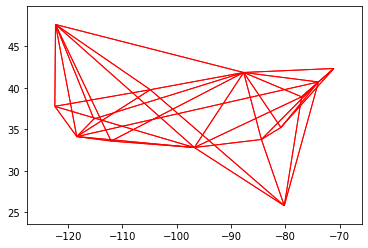

In [614]:
plan_list=[]
cost_thr=5000
for name1 in detour_table.namelist:
    for name2 in detour_table.namelist:
        if traffic_table.get(name1,name2)!=0 and detour_table.get(name1,name2)>=cost_thr:
            tra=traffic_table.get(name1,name2)
            orig_node,transfer_node,dest_node=analyze_route_bidirectional(mygraph,name1,name2,cities,traffic_table)
            cost=(15+tra)*distance(cities,orig_node,transfer_node)+tra*distance(cities,transfer_node,dest_node)
            
            plan_list.append([orig_node,transfer_node,dest_node,cost])
plan_list=sorted(plan_list,key=lambda x:x[3])
#print(plan_list)
addcities(mygraph,cities,plan_list[0][0],plan_list[0][1])
for p in plan_list[1:]:
    spt=mygraph.getSPT(p[0],False)
    d=0
    temp=p[2]
    while temp!=p[0]:
        nexttemp=list(spt.graph[temp].keys())[0]
        d+=list(spt.graph[temp].values())[0]
        temp=nexttemp
    d-=distance(cities,p[0],p[2])
    cost=d*(traffic_table.get(p[0],p[2])+traffic_table.get(p[2],p[0]))
    if cost>=cost_thr:
        addcities(mygraph,cities,p[0],p[1])
mygraph.visualize()


In [615]:
'''c1="Raleigh,NC"
c2s=["New York,NY","Los Angeles,CA","Seattle,WA","Miami,FL"]
for c2 in c2s:
    traffic_table.set(c1,c2,50)
city,cost=analyze_route_multi_dest(mygraph,c1,c2s,cities,traffic_table)
print(city)
addcities(mygraph,cities,c1,city)
mygraph.visualize()'''

'c1="Raleigh,NC"\nc2s=["New York,NY","Los Angeles,CA","Seattle,WA","Miami,FL"]\nfor c2 in c2s:\n    traffic_table.set(c1,c2,50)\ncity,cost=analyze_route_multi_dest(mygraph,c1,c2s,cities,traffic_table)\nprint(city)\naddcities(mygraph,cities,c1,city)\nmygraph.visualize()'

In [616]:
mygraph.sum_length(cities)

56678.6839304752

In [617]:
orig_traffic_table=NbyNTable(city_list)
with open("traffic.csv") as file:
    spamreader = csv.reader(file,delimiter=',')
    for row in spamreader:
        a=row[0]+','+row[1]
        b=row[2]+','+row[3]
        c=int(row[4])
        orig_traffic_table.set(a,b,c)
edge_traffic,distance_table,transfer_traffic=mygraph.traffic(orig_traffic_table,cities)
detour_table=detour_cost(distance_table,traffic_table,cities)


In [618]:
decost=0
for i in range(len(detour_table.namelist)):
    for j in range(len(detour_table.namelist)):
        if detour_table.table[i,j]!=np.inf:
            decost+=detour_table.table[i,j]
print(decost)

54648.03119396308
